In [1]:
# =======================================================================
#  Three-Day, 16-Stack Li-ion Battery Bank
#  ======================================
#  • Module type  : Sungrow SBR128   (12.8 kWh per stack)
#  • Stack count  : 16
#  • Autonomy     : 3 days of average CBS load
#  • DoD design   : 70 %  ⇒ SOC_min = 0.30
#  • η (cells+PCS): η_BC = η_BD = 0.96   (≈92 % round-trip)
# =======================================================================

from myLibs.backupPowerSystems import EnergyStorageSystem

# -----------------------------------------------------------------------
# 1 · Capacity calculation (done implicitly by the class)
#     E_B = 12.8 kWh/stack × 16 stacks × 3 days  = 614.4 kWh
# -----------------------------------------------------------------------
ess = EnergyStorageSystem(
    stacks=16,        # number of SBR128 modules
    autonomy_days=3,  # days of load to be covered
    soc=0.30          # start at the DoD-limited floor (30 % SOC)
)

# -----------------------------------------------------------------------
# 2 · Derived quantities for confirmation
# -----------------------------------------------------------------------
print(f"Nominal capacity  (E_B)     : {ess.E_B:.2f} kWh")        # 614.40 kWh
print(f"Usable window (70 % DoD)    : {(1-ess.soc_min)*100:.0f}% "
      f"→ {ess.E_B*(1-ess.soc_min):.2f} kWh")
print(f"Initial stored energy       : {ess.energy_kwh:.2f} kWh") # 184.32 kWh
print(f"SOC limits (min / max)      : {ess.soc_min:.0%} – {ess.soc_max:.0%}")
print(f"Round-trip efficiency (est.) : {(ess.eta_c*ess.eta_d):.0%}")

Nominal capacity  (E_B)     : 614.40 kWh
Usable window (70 % DoD)    : 80% → 491.52 kWh
Initial stored energy       : 184.32 kWh
SOC limits (min / max)      : 20% – 90%
Round-trip efficiency (est.) : 92%


In [2]:
# ======================================================================
#  PV-Driven Charging Simulation  —  Li-ion Bank (20 % ↔ 90 % SOC window)
# ======================================================================
#  Data source : Data\Test\PowerGeneration_Solar__10_20_Jan_2025.csv
#  Time step   : 1-hour samples  (Δt = 1 h → one loop = one Eq. 4 update)
#
#  ESS model   : Three-day / 16-stack Sungrow SBR128 bank created earlier
#                • Nominal capacity      E_B   = 614.4 kWh
#                • Operating window      20 % – 90 % SOC  (usable 70 %)
#                • Start of this test    SOC₀  = 30 %
#
#  Theory (Eq. 4)
#      SOC_B(t) = SOC_B(t−1) + [ P_BC·η_c − P_BD/η_d ] · Δt / E_B
#      Here   P_BD = 0  because the battery is **only charging** from PV.
#
#  Objective
#      • Determine how many daylight hours in the PV profile are needed
#        to raise SOC from 30 % to the upper limit 90 %.
#      • Plot both trajectories on one figure:
#          left-axis  →  SOC [%] of the ESS
#          right-axis →  PV array power [kW]
# ======================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ────────────────────────────────────────────────────────────────────
# 1 · Load hourly PV profile (Timestamp → datetime, PV_kW → float)
# ────────────────────────────────────────────────────────────────────
df = pd.read_csv(
    r"Data\Test\PowerGeneration_Solar__10_20_Jan_2025.csv",
    parse_dates=["Timestamp"]
)

# ────────────────────────────────────────────────────────────────────
# 2 · Simulate charging hour-by-hour and record SOC history
# ────────────────────────────────────────────────────────────────────
soc_hist = []                      # SOC at *end* of each simulated hour

for pv_kw in df["PV_kW"]:
    # Energy increment per Eq. 4   (P_BD = 0 while charging)
    soc, _, _ = ess.charge(p_in_kw=pv_kw, dt_hr=1.0)
    soc_hist.append(round(soc * 100, 2))          # store as % (2 d.p.)

    # Stop once the bank reaches its design ceiling (90 %)
    if soc >= ess.soc_max:
        break

# Retain rows actually simulated and append SOC column
df = df.iloc[:len(soc_hist)].copy()
df["SOC_%"] = soc_hist

# ────────────────────────────────────────────────────────────────────
# 3 · Summary result
# ────────────────────────────────────────────────────────────────────
print(f"Hours required to charge from 30 % to 90 % SOC: {len(soc_hist):.0f} h")

Hours required to charge from 30 % to 90 % SOC: 243 h


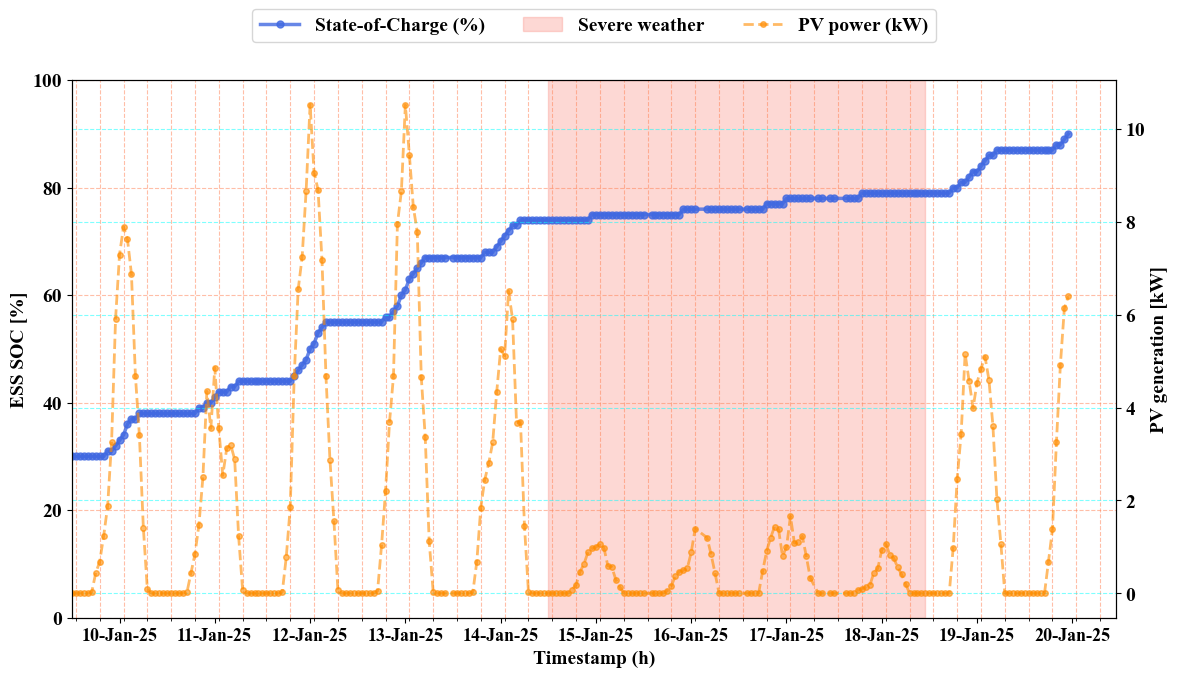

In [3]:
# ────────────────────────────────────────────────────────────────────
# 4 · Dual-axis plot — SOC % (left) & PV kW (right)
# ────────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Global font settings
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]   = 14
plt.rcParams["font.weight"] = "bold"

fig, ax_soc = plt.subplots(figsize=(12, 7))

# ─── 1 · Primary Y-axis : ESS SOC [%] ────────────────────────────────
ax_soc.plot(df["Timestamp"],
            df["SOC_%"],
            color='royalblue',
            linewidth=2.5,
            marker='o',
            markersize=5,
            alpha=0.8,
            label='State-of-Charge (%)')
ax_soc.set_ylabel('ESS SOC [%]', fontweight='bold')
ax_soc.set_ylim(0, 100)

# ─── 2 · Secondary Y-axis : PV power [kW] ────────────────────────────
ax_pv = ax_soc.twinx()
ax_pv.plot(df["Timestamp"],
           df["PV_kW"],
           color='darkorange',
           linewidth=2,
           linestyle='--',
           marker='o',
           markersize=4,
           alpha=0.6,
           label='PV power (kW)')
ax_pv.set_ylabel('PV generation [kW]', fontweight='bold')

# ─── 3 · X-axis ticks, limits, grid  ────────────────────────────────
ax_soc.set_xlabel('Timestamp (h)', fontweight='bold')

# Major ticks → every day at midnight+12 h so the date label is centred
ax_soc.xaxis.set_major_locator(mdates.HourLocator(byhour=12))
ax_soc.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# Minor ticks → every 6 h
ax_soc.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# Vertical grid on minor ticks; horizontal grid on major y-ticks
ax_soc.grid(which='minor', axis='x', linestyle='--', color='coral', alpha=0.5)
ax_soc.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)
ax_pv .grid(which='major', axis='y', linestyle='--', color='cyan' , alpha=0.5)

# X-axis range: 10 Jan 00:00 → 20 Jan 23:00
start = pd.Timestamp("2025-01-10 00:00")
end   = pd.Timestamp("2025-01-20 23:00")
ax_soc.set_xlim(start, end)

# Keep x-labels horizontal
ax_soc.tick_params(axis='x', rotation=0, labelsize=13)

# ─── 4 · Optional shading (e.g. severe-weather window) ───────────────
ax_soc.axvspan(pd.Timestamp("2025-01-15 00:00"),
               pd.Timestamp("2025-01-18 23:00"),
               color='salmon', alpha=0.3,
               label='Severe weather')

# ─── 5 · Combined legend centred above axes  ─────────────────────────
lines1, labels1 = ax_soc.get_legend_handles_labels()
lines2, labels2 = ax_pv .get_legend_handles_labels()
ax_soc.legend(lines1 + lines2,
              labels1 + labels2,
              loc='upper center',
              bbox_to_anchor=(0.5, 1.15),
              ncol=3,
              frameon=True)

plt.tight_layout()
plt.savefig("Figures/ESS_SOC_vs_PV_10-20_Jan_2025.png",
            dpi=600, bbox_inches='tight')
# plt.show()    # uncomment if you want the window to appear

Hours until SOC reached 20%: 87 h


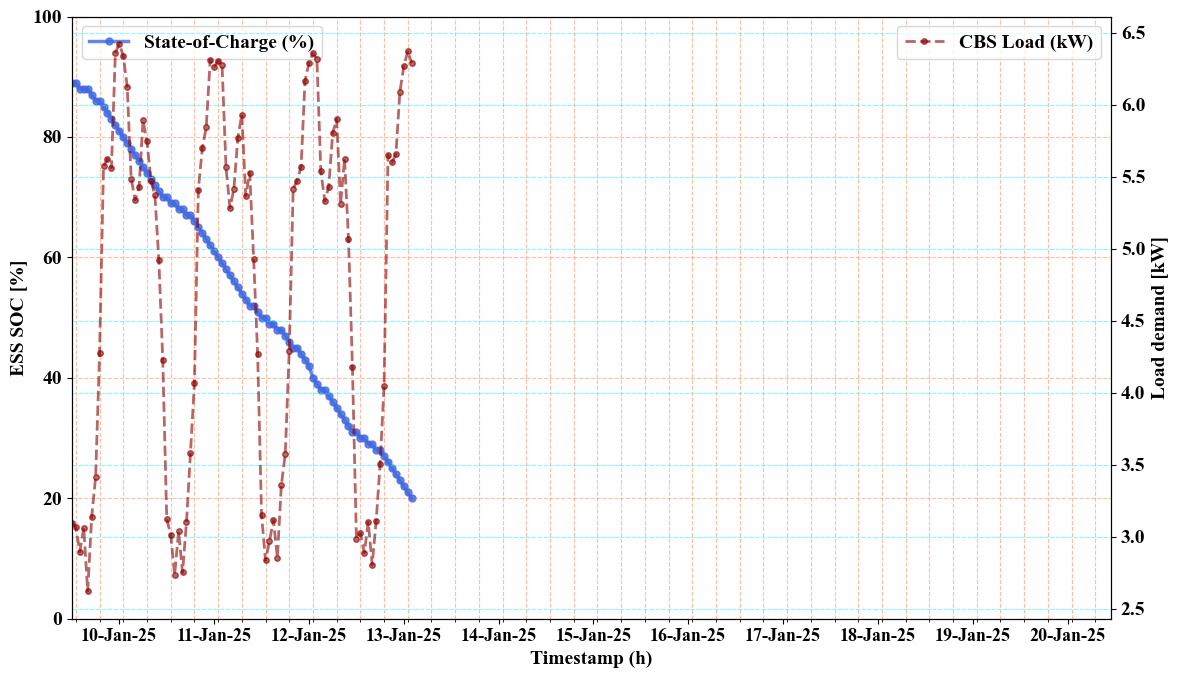

In [4]:
"""
Discharge-only run
────────────────────────────────────────────────────────────────────────
• CSV            : Data\Test\PowerDemand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv
• ESS model      : 16 × SBR128   |  η = 0.96
                    SOC window   : 20 %  ↔  90 %  (usable 70 %)
• Initial SOC    : 90 %  (not 100 % — last charge cycle stops at the ceiling)
• Time step      : 1 h   (exactly one row per hour in the file)
• Deliverable    : figure with
      – left  Y-axis →  ESS SOC  [%]
      – right Y-axis →  CBS load [kW]
      – X-axis       →  full timestamp labels (hourly)
────────────────────────────────────────────────────────────────────────
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from myLibs.backupPowerSystems import EnergyStorageSystem

# ────────────────────────── global font style ─────────────────────────
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size"  : 14,
    "font.weight": "bold"
})

# ─────────────────────────── 1 · Load demand CSV ──────────────────────
df = (
    pd.read_csv(
        r"Data\Test\PowerDemand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv",
        parse_dates=["Timestamp"]
    )
    .rename(columns={"CBSs_kW": "Load_kW"})
    .set_index("Timestamp", drop=True)
)

# ─────────────────────────── 2 · ESS initialised at 90 % ──────────────
ess = EnergyStorageSystem(soc=0.90)        # ⇐ upper limit of window
# initial stored energy = 0.90 · 614.4 ≈ 553 kWh
soc_hist = []                               # SOC % after each simulated hour

for load_kw in df["Load_kW"]:
    soc, _, _ = ess.discharge(load_kw=load_kw, dt_hr=1.0)
    soc_hist.append(round(soc * 100, 2))    # two-decimal %
    if soc <= ess.soc_min:                  # 20 % floor reached
        break

df = df.iloc[:len(soc_hist)].copy()
df["SOC_%"] = soc_hist

# ─────────────────────────── 3 · Summary output ───────────────────────
print(f"Hours until SOC reached {ess.soc_min:.0%}: {len(soc_hist):.0f} h")

# ─────────────────────────── 4 · Styled dual-axis plot ────────────────
fig, ax_soc = plt.subplots(figsize=(12, 7))

# Left axis → SOC
ax_soc.plot(df.index, df["SOC_%"],
            color="royalblue", linewidth=2.5, marker="o", markersize=5,
            alpha=0.8, label="State-of-Charge (%)")
ax_soc.set_ylabel("ESS SOC [%]", fontweight="bold")
ax_soc.set_ylim(0, 100)

# Right axis → CBS load
ax_load = ax_soc.twinx()
ax_load.plot(df.index, df["Load_kW"],
             color="darkred", linestyle="--", linewidth=2,
             marker="o", markersize=4, alpha=0.6, label="CBS Load (kW)")
ax_load.set_ylabel("Load demand [kW]", fontweight="bold")

# X-axis ticks and grid
ax_soc.xaxis.set_major_locator(mdates.HourLocator(byhour=12))
ax_soc.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ax_soc.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax_soc.grid(which='minor', axis='x', linestyle='--', color='coral', alpha=0.5)
ax_soc.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)
ax_load.grid(which='major', axis='y', linestyle='--', color='cyan',  alpha=0.5)

ax_soc.set_xlim(pd.Timestamp("2025-01-10 00:00"),
                pd.Timestamp("2025-01-20 23:00"))
ax_soc.set_xlabel("Timestamp (h)", fontweight="bold")
ax_soc.tick_params(axis='x', rotation=0, labelsize=13)

# Separate legends (avoid overlap)
ax_soc.legend(loc="upper left",  frameon=True)
ax_load.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.savefig("Figures/ESS_Discharge_SOC_vs_Load_10-20_Jan_2025.png",
            dpi=600, bbox_inches='tight')
# plt.show()

In [5]:
"""
Strategic ESS Dispatch
──────────────────────────────────────────────────────────────────────────
Scenario        : Wollongong micro-grid, 10 – 20 Jan 2025  
Data inputs     : • Solar   →  PV_kW   (hourly)  
                  • Wind    →  WT_kW   (hourly)  
                  • Critical load → CBSs_kW (hourly)  
Battery model   : 16 × SBR128 (Li-ion, 20 – 90 % SOC window, 3-day autonomy)

Control policy
──────────────
A. Pre-event      (≤ 15 Jan 14 h 20 m)  
     – maximize RES self-consumption  
     – stage ESS to ≥ 90 % SOC using **minimal** grid support  
B. Severe window  (15 Jan 14 h 20 m → 18 Jan 22 h 59 m)  
     – serve load from RES → ESS → grid (last resort)  
C. Post-event     (≥ 19 Jan 00 h)  
     – return to RES-priority operation; grid only if ESS hits 20 % floor
Outputs
───────
• Hourly SOC trajectory for plotting  
• Grid energy imported with strategy vs. “no-RES” baseline  
• SOC at start/end of severe period (nearest hour)
"""

import pandas as pd
from myLibs.backupPowerSystems import EnergyStorageSystem

# ──────────────────────────────────────────────────────────────
# 0 · Load and merge the three hourly CSV files
# ──────────────────────────────────────────────────────────────
pv = (pd.read_csv(r"Data\Test\PowerGeneration_Solar__10_20_Jan_2025.csv",
                  parse_dates=["Timestamp"])
        .set_index("Timestamp")[["PV_kW"]])

wt = (pd.read_csv(r"Data\Test\PowerGeneration_Wind__10_20_Jan_2025.csv",
                  parse_dates=["Timestamp"])
        .set_index("Timestamp")[["WT_kW"]])

load = (pd.read_csv(r"Data\Test\PowerDemand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv",
                    parse_dates=["Timestamp"])
          .set_index("Timestamp")[["CBSs_kW"]])

df = (pv.join(wt, how="outer")
        .join(load, how="outer")
        .fillna(0.0)                # any missing hour → 0 kW
        .sort_index())

df["TRE_kW"] = df["PV_kW"] + df["WT_kW"]   # total renewable supply
df["SOC_%"]  = None                        # placeholder for logging

# ──────────────────────────────────────────────────────────────
# 1 · Instantiate ESS   (E_B = 614.4 kWh, SOC window 20–90 %)
#     Start at 30 % = conservative reserve after previous storm
# ──────────────────────────────────────────────────────────────
ess = EnergyStorageSystem(stacks=16, autonomy_days=3, soc=0.30)

# ──────────────────────────────────────────────────────────────
# 2 · Define severe-weather window (minute resolution)
# ──────────────────────────────────────────────────────────────
t_sev_start = pd.Timestamp("2025-01-15 14:20")
t_sev_end   = pd.Timestamp("2025-01-18 22:59")

def hrs_to_severe(ts: pd.Timestamp) -> float:
    """Return whole hours until the severe window opens."""
    return max(0, (t_sev_start - ts).total_seconds() / 3600)

# ──────────────────────────────────────────────────────────────
# 3 · Dispatch loop — iterate one hour at a time
# ──────────────────────────────────────────────────────────────
grid_energy_kwh = 0.0            # cumulative grid import

for ts, row in df.iterrows():

    P_res   = row.TRE_kW          # renewable generation this hour
    P_load  = row.CBSs_kW         # critical demand

    # 3A · PRE-EVENT  (stage battery to 90 % SOC)
    if ts < t_sev_start:

        # calculate minimal grid power to meet 90 % by the deadline
        soc_gap  = max(0, 0.90 - ess.soc)
        hrs_left = max(1, hrs_to_severe(ts))
        P_grid   = soc_gap * ess.E_B / hrs_left   # kW for this hour

        # use renewable surplus first
        ess.charge(max(0, P_res - P_load), dt_hr=1)

        # if still below 90 % → import the scheduled grid power
        if ess.soc < 0.90 and P_grid > 0:
            ess.charge(P_grid, dt_hr=1)
            grid_energy_kwh += P_grid           # kWh (Δt = 1 h)

        # cover residual deficit from battery
        ess.discharge(max(0, P_load - P_res), dt_hr=1)

    # 3B · SEVERE-EVENT  (RES → ESS → grid fallback)
    elif t_sev_start <= ts <= t_sev_end:

        net_deficit = max(0, P_load - P_res)
        if net_deficit > 0:
            soc_pre = ess.soc
            ess.discharge(net_deficit, dt_hr=1)
            supplied = (soc_pre - ess.soc) * ess.E_B
            remaining = net_deficit - supplied
            if remaining > 1e-3:                # ESS depleted
                grid_energy_kwh += remaining

    # 3C · POST-EVENT  (normal RES-priority)
    else:
        ess.charge(max(0, P_res - P_load), dt_hr=1)

        deficit = max(0, P_load - P_res)
        if deficit > 0:
            ess.discharge(deficit, dt_hr=1)
            if ess.soc <= ess.soc_min:          # hit 20 % floor
                grid_energy_kwh += deficit

    # log hourly SOC for later plotting
    df.at[ts, "SOC_%"] = round(ess.soc * 100, 2)

# ──────────────────────────────────────────────────────────────
# 4 · Helper to retrieve SOC nearest to an arbitrary timestamp
# ──────────────────────────────────────────────────────────────
def nearest_val(series: pd.Series, ts: pd.Timestamp) -> float:
    idx = series.index.get_indexer([ts], method="nearest")[0]
    return series.iloc[idx]

# ──────────────────────────────────────────────────────────────
# 5 · Energy accounting & console report
# ──────────────────────────────────────────────────────────────
E_res   = df["TRE_kW"].sum()                       # kWh of RES available
E_load  = df["CBSs_kW"].sum()                      # kWh load demand
E_noRES = E_load + 0.60*ess.E_B/ess.eta_c          # grid w/out RES

print("────────────  Dispatch Summary  ────────────")
print(f"Grid import (strategy)        : {grid_energy_kwh:7.0f} kWh")
print(f"Grid import (no RES baseline) : {E_noRES:7.0f} kWh")
print(f"Renewable energy available    : {E_res:7.0f} kWh")
print(f"SOC @ window open  (≈14:20)   : {nearest_val(df['SOC_%'], t_sev_start):5.1f} %")
print(f"SOC @ window close (≈22:59)   : {nearest_val(df['SOC_%'], t_sev_end  ):5.1f} %")

────────────  Dispatch Summary  ────────────
Grid import (strategy)        :     585 kWh
Grid import (no RES baseline) :    1740 kWh
Renewable energy available    :    1943 kWh
SOC @ window open  (≈14:20)   :  89.3 %
SOC @ window close (≈22:59)   :  60.3 %


In [21]:
"""
Multi-stream Power Plot  —  Wollongong (10 – 20 Jan 2025)
────────────────────────────────────────────────────────────────────────
Panel order (top→bottom):  CBSs (kW)  →  Grid (kW)  →  Solar (kW)
                           →  Wind (kW)  →  ESS (kW)

Grid panel now shows **two curves**
    • import  = positive values   (black)
    • export  = surplus RES sold  (gold, plotted negative ⇒ downwards)

Style: Times-bold, 6-hour vertical grid, shaded severe-weather window,
       8 × 9-inch canvas.
"""

# ───────────────────────── 0 · Imports & global style ─────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
from myLibs.backupPowerSystems import EnergyStorageSystem

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size"  : 13,
    "font.weight": "bold"
})

# ───────────────────────── 1 · Load hourly CSV files ──────────────────────────
pv   = (pd.read_csv(r"Data\Test\PowerGeneration_Solar__10_20_Jan_2025.csv",
                    parse_dates=["Timestamp"])
          .set_index("Timestamp")[["PV_kW"]])

wt   = (pd.read_csv(r"Data\Test\PowerGeneration_Wind__10_20_Jan_2025.csv",
                    parse_dates=["Timestamp"])
          .set_index("Timestamp")[["WT_kW"]])

load = (pd.read_csv(r"Data\Test\PowerDemand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv",
                    parse_dates=["Timestamp"])
          .set_index("Timestamp")[["CBSs_kW"]])

df = (pv.join(wt, how="outer")
        .join(load, how="outer")
        .fillna(0.0)
        .sort_index())

df["TRE_kW"]        = df["PV_kW"] + df["WT_kW"]
df["Charge_kW"]     = 0.0        # ESS charging (kW)
df["Discharge_kW"]  = 0.0        # ESS discharging (kW)
df["Grid_Imp_kW"]   = 0.0        # Grid import  (+)
df["Grid_Exp_kW"]   = 0.0        # Grid export  (+ ⇒ drawn downward)
df["SOC_%"]         = None

# ───────────────────────── 2 · ESS model & control marks ──────────────────────
ess         = EnergyStorageSystem(stacks=16, autonomy_days=3, soc=0.30)
t_sev_start = pd.Timestamp("2025-01-15 14:20")
t_sev_end   = pd.Timestamp("2025-01-18 22:59")
def hrs_to_severe(ts): return max(0, (t_sev_start-ts).total_seconds()/3600)

def discharge_to_floor(request_kw):
    """Supply up to *request_kw* kW from ESS (1 h) respecting 20 % SOC floor."""
    soc_before = ess.soc
    ess.discharge(request_kw, dt_hr=1)
    supplied = (soc_before - ess.soc) * ess.E_B
    return supplied, request_kw - supplied

# ───────────────────────── 3 · Hour-by-hour dispatcher ────────────────────────
for ts, row in df.iterrows():

    P_res  = row.TRE_kW
    P_load = row.CBSs_kW
    e_prev = ess.energy_kwh

    # ▸ A · PRE-EVENT (charge up to 90 %)
    if ts < t_sev_start:
        gap = max(0, 0.90 - ess.soc)
        P_grid_plan = gap * ess.E_B / max(1, hrs_to_severe(ts))

        # (i) meet load with RES first
        surplus = max(0, P_res - P_load)
        ess.charge(surplus, 1)

        # (ii) planned grid top-up if still < 90 %
        if ess.soc < 0.90 and P_grid_plan > 0:
            ess.charge(P_grid_plan, 1)
            df.at[ts, "Grid_Imp_kW"] = P_grid_plan

        # (iii) any residual deficit → ESS (then grid)
        deficit = max(0, P_load - P_res)
        supplied, rem = discharge_to_floor(deficit)
        if rem > 1e-3:
            df.at[ts, "Grid_Imp_kW"] += rem

        # (iv) surplus after ESS full → export
        extra = max(0, P_res - P_load - supplied - P_grid_plan)
        if extra > 1e-3 and ess.soc >= 0.90 - 1e-4:
            df.at[ts, "Grid_Exp_kW"] = extra

    # ▸ B · SEVERE WINDOW (grid last resort)
    elif t_sev_start <= ts <= t_sev_end:
        deficit = max(0, P_load - P_res)
        if deficit:
            supplied, rem = discharge_to_floor(deficit)
            if rem > 1e-3:
                df.at[ts, "Grid_Imp_kW"] = rem
        # export never happens in the storm window

    # ▸ C · POST-EVENT (normal RES-priority + sell surplus)
    else:
        # meet load with RES first
        surplus = max(0, P_res - P_load)
        ess.charge(surplus, 1)

        deficit = max(0, P_load - P_res)
        supplied, rem = discharge_to_floor(deficit)
        if rem > 1e-3:
            df.at[ts, "Grid_Imp_kW"] = rem

        # if ESS now full, sell remaining RES to grid
        extra = max(0, P_res - P_load - supplied)
        if extra > 1e-3 and ess.soc >= ess.soc_max - 1e-4:
            df.at[ts, "Grid_Exp_kW"] = extra

    # ▸ log ESS flows
    delta_e = ess.energy_kwh - e_prev
    if delta_e >= 0:
        df.at[ts, "Charge_kW"]    =  delta_e
    else:
        df.at[ts, "Discharge_kW"] = -delta_e
    df.at[ts, "SOC_%"] = round(ess.soc * 100, 2)


# ───────────────────────── 4 · Energy accounting & console report ────────────
# helper for SOC at arbitrary timestamp (nearest hour)
def nearest_val(series: pd.Series, ts: pd.Timestamp) -> float:
    idx = series.index.get_indexer([ts], method="nearest")[0]
    return series.iloc[idx]

E_res     = df["TRE_kW"].sum()                        # kWh of renewables
E_load    = df["CBSs_kW"].sum()                       # kWh demand
E_imp     = df["Grid_Imp_kW"].sum()                   # kWh bought
E_exp     = df["Grid_Exp_kW"].sum()                   # kWh sold
E_noRES   = E_load + 0.60*ess.E_B/ess.eta_c           # grid if no RES
net_grid  = E_imp - E_exp                            # positive = net import

print("────────── Dispatch Summary (10–20 Jan 2025) ──────────")
print(f"Renewable energy available      : {E_res:8.0f} kWh")
print(f"Grid import (strategy)          : {E_imp:8.0f} kWh")
print(f"Grid export (surplus RES sold)  : {E_exp:8.0f} kWh")
print(f"Net grid balance                : {net_grid:8.0f} kWh")
print(f"Grid import (no-RES baseline)   : {E_noRES:8.0f} kWh")
print(f"SOC  at window open   (≈14:20)  : {nearest_val(df['SOC_%'], t_sev_start):5.1f} %")
print(f"SOC  at window close  (≈22:59)  : {nearest_val(df['SOC_%'], t_sev_end  ):5.1f} %")
print("────────────────────────────────────────────────────────")


────────── Dispatch Summary (10–20 Jan 2025) ──────────
Renewable energy available      :     1943 kWh
Grid import (strategy)          :      585 kWh
Grid export (surplus RES sold)  :       82 kWh
Net grid balance                :      503 kWh
Grid import (no-RES baseline)   :     1740 kWh
SOC  at window open   (≈14:20)  :  89.3 %
SOC  at window close  (≈22:59)  :  60.3 %
────────────────────────────────────────────────────────


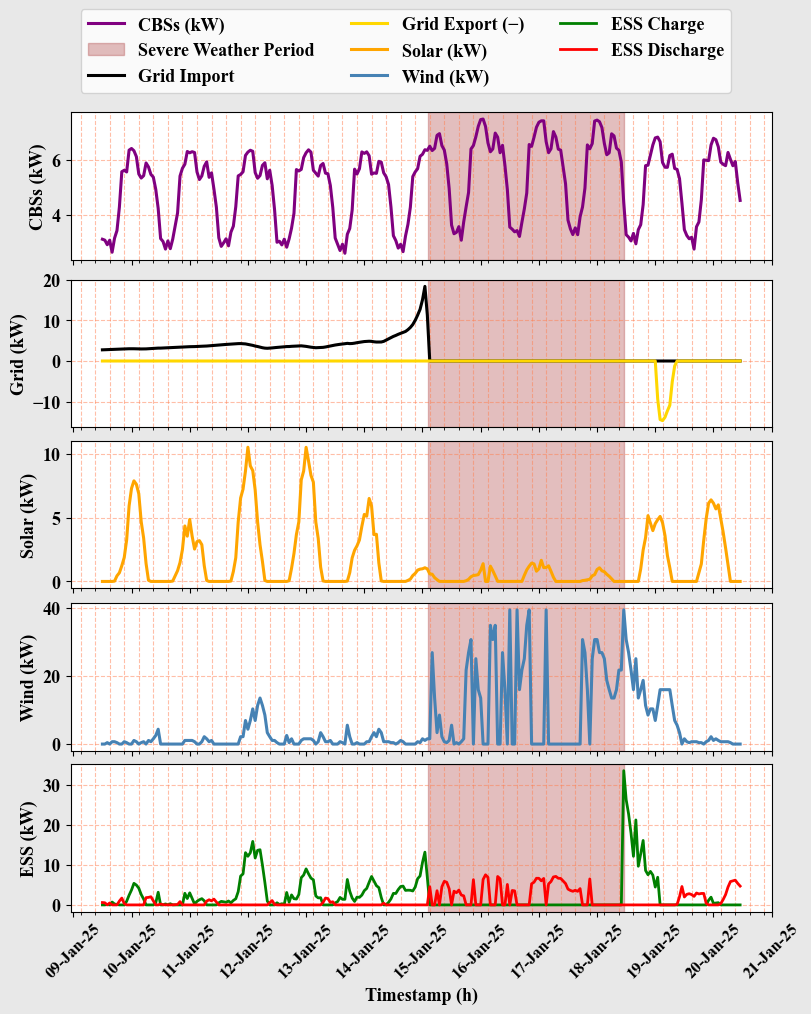

In [23]:
# ───────────────────────── 4 · Build five-panel figure ──────────────────────
from matplotlib.colors import to_rgba    # already imported earlier

fig, axes = plt.subplots(
    5, 1, figsize=(8, 9),
    sharex=True, constrained_layout=True         # replaces tight_layout
)

# 50 %-opaque grey canvas
fig.patch.set_facecolor(to_rgba('lightgray', 0.50))

def shade(ax):
    """Highlight the severe-weather window."""
    ax.axvspan(t_sev_start, t_sev_end, color="brown", alpha=0.30,
               label="Severe Weather Period")

# ───── Row 0 — CBSs (critical load) ─────────────────────────────────────────
axes[0].plot(df.index, df["CBSs_kW"], color="purple", lw=2.2,
             label="CBSs (kW)")
axes[0].set_ylabel("CBSs (kW)", fontweight="bold")
shade(axes[0])

# ───── Row 1 — Grid import / export ────────────────────────────────────────
imp_line,  = axes[1].plot(df.index,  df["Grid_Imp_kW"],
                          color="black", lw=2.2, label="Grid Import")
exp_line,  = axes[1].plot(df.index, -df["Grid_Exp_kW"],
                          color="gold",  lw=2.2, label="Grid Export (−)")
axes[1].set_ylabel("Grid (kW)", fontweight="bold")
shade(axes[1])

# ───── Row 2 — Solar power ────────────────────────────────────────────────
axes[2].plot(df.index, df["PV_kW"], color="orange", lw=2.2,
             label="Solar (kW)")
axes[2].set_ylabel("Solar (kW)", fontweight="bold")
shade(axes[2])

# ───── Row 3 — Wind power ─────────────────────────────────────────────────
axes[3].plot(df.index, df["WT_kW"], color="steelblue", lw=2.2,
             label="Wind (kW)")
axes[3].set_ylabel("Wind (kW)", fontweight="bold")
shade(axes[3])

# ───── Row 4 — ESS charge / discharge ─────────────────────────────────────
ch_line, = axes[4].plot(df.index, df["Charge_kW"],
                        color="green", lw=2, label="ESS Charge")
ds_line, = axes[4].plot(df.index, df["Discharge_kW"],
                        color="red",   lw=2, label="ESS Discharge")
axes[4].set_ylabel("ESS (kW)", fontweight="bold")
shade(axes[4])

# ───── X-axis ticks & label ───────────────────────────────────────────────
axes[-1].xaxis.set_major_locator(mdates.HourLocator(byhour=12))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))
axes[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=6))
axes[-1].tick_params(axis="x", rotation=45, labelsize=12)
axes[-1].set_xlabel("Timestamp (h)", fontweight="bold")

# ───── Uniform grid style ─────────────────────────────────────────────────
for ax in axes:
    ax.grid(which="minor", axis="x", linestyle="--",
            color="coral", alpha=0.5)
    ax.grid(which="major", axis="y", linestyle="--",
            color="coral", alpha=0.5)

# ───── Combined legend (single entry per label) ──────────────────────────
handles, labels = [], []
for ax in axes:                              # collect from every subplot
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# drop duplicates while preserving order
seen = set()
uniq_handles, uniq_labels = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        uniq_handles.append(h)
        uniq_labels.append(l)
        seen.add(l)


fig.legend(uniq_handles, uniq_labels,
           loc="upper center", bbox_to_anchor=(0.5, 1.12),
           ncol=3, frameon=True)


fig.savefig("Figures/Wollongong_Resilient_Power_System_10_20_Jan_2025.png",
            dpi=600, bbox_inches='tight')

# plt.show()